In [23]:
%load_ext autoreload
%autoreload 2

from nca.models import BaselineNCA, FCInvAE
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from kornia import augmentation

from tqdm.auto import tqdm
import base64
import matplotlib
from io import BytesIO
from PIL import Image
from IPython.display import HTML

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
def make_gif(nca_out, fps=10):
    seq_out = nca_out.detach().cpu().numpy()
    pil_arrs = (plt.cm.viridis(seq_out)[:,:,:,:3] * 255).astype(np.uint8)
    pils = [Image.fromarray(arr).resize((500, 500), Image.NEAREST) for arr in pil_arrs]
    
    fp = BytesIO()
    pils[0].save(
        fp,
        format="gif",
        save_all=True,
        append_images=pils[1:],
        duration=1000 / fps,
        loop=0,
    )
    fp.seek(0)
    
    b64 = base64.b64encode(fp.read()).decode("ascii")
    html = f"""<img src="data:image/gif;base64,{b64}" />"""
    return HTML(html)

In [25]:
device = "cuda"

In [88]:
sampled_nca = BaselineNCA(hidden_n=20, zero_w2=False).to(device)

In [89]:
S, s = 64, 32
image_rep = torch.zeros(1, 4, S, S).to(device)
torch.nn.init.normal_(image_rep[:, :, S // 2 - s // 2:S // 2 + s // 2, S // 2 - s // 2:S // 2 + s // 2])
b, c, h, w = image_rep.shape

nca_out = sampled_nca.forward_many(image_rep, steps=60)
nca_out = torch.stack(nca_out)

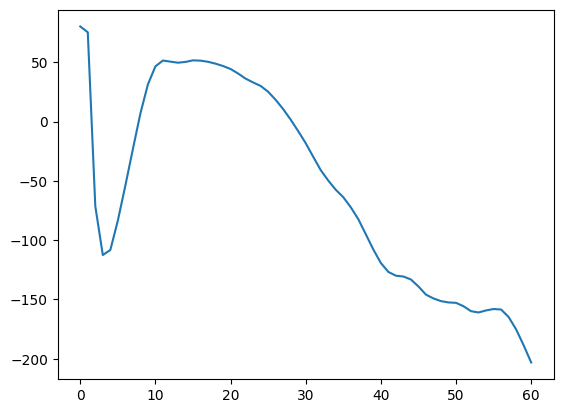

In [90]:
vs = nca_out.reshape(nca_out.shape[0], -1).sum(axis=1).detach().cpu()
plt.plot(vs)

In [91]:
nca_out[0].sum(), nca_out[1].sum(), nca_out[5].sum(), nca_out[30].sum()

(tensor(80.1563, device='cuda:0', grad_fn=<SumBackward0>),
 tensor(75.2808, device='cuda:0', grad_fn=<SumBackward0>),
 tensor(-83.5169, device='cuda:0', grad_fn=<SumBackward0>),
 tensor(-18.2761, device='cuda:0', grad_fn=<SumBackward0>))


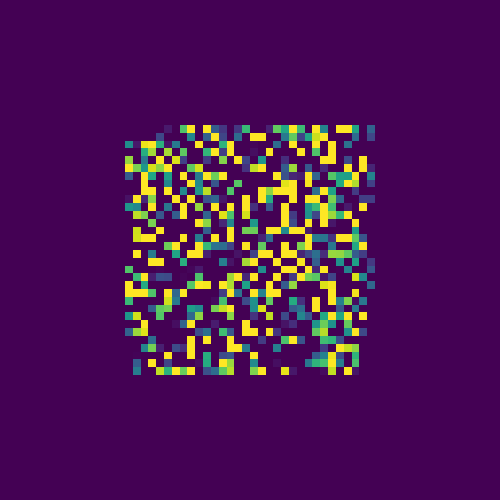

In [92]:
make_gif(nca_out[:,0,0], fps=10)

In [93]:
noise_size = 1
noiser = nn.Sequential(
#     augmentation.RandomAffine(
#         degrees=60,
#         translate=[0.1, 0.1],
#         scale=[0.9, 1.1],
#         shear=[-10, 10],
#     ),
    augmentation.RandomPerspective(0.6, p=0.5),
    augmentation.RandomBoxBlur(kernel_size=(5, 5), p=noise_size),
#     augmentation.RandomErasing((0.1, 0.2), (0.3, 1 / 0.3), p=noise_size),
    # augmentation.RandomJigsaw(grid=(4, 4) ,p=noise_size),
    augmentation.RandomGaussianNoise(0, 0.25, same_on_batch=False, p=noise_size),
)

In [94]:
from copy import deepcopy

In [95]:
inv_ae = FCInvAE(msg_size=8, frame_size=128).to(device)
nca = deepcopy(sampled_nca)
lr = 0.001
optim = torch.optim.Adam(list(nca.parameters()) + list(inv_ae.parameters()), lr=lr)
history = []

bs = 100
steps = 30
its = 1000

pbar = tqdm(range(its))
for e in pbar:
    msg = inv_ae.sample_msg(bs)
    image = inv_ae.encode(msg)
    image_rep = image.repeat(1, 4, 1, 1)
    nca_out = nca.forward_many(image_rep, steps=steps)
    nca_out = torch.stack(nca_out)

    last_frame = nca_out[-5:].reshape(-1, *nca_out.shape[2:])
    last_frame = noiser(last_frame)[:,0]
    decode_inp = last_frame.reshape(last_frame.shape[0], -1)
    decoded_msg = inv_ae.decode(decode_inp)

    msg_rep = msg.unsqueeze(0).repeat(5, 1, 1).view(-1, msg.shape[-1])
    loss = F.mse_loss(decoded_msg, msg_rep)

    optim.zero_grad()
    loss.backward()
    optim.step()

    pbar.set_description(f"Loss: {loss.item():0.6f}")
    history.append(loss.item())

  0%|          | 0/1000 [00:00<?, ?it/s]

In [55]:
nca_out = nca_out.detach().cpu()

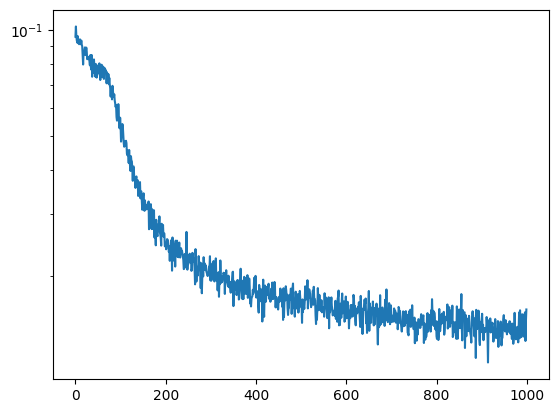

In [47]:
plt.plot(history)
plt.yscale("log")

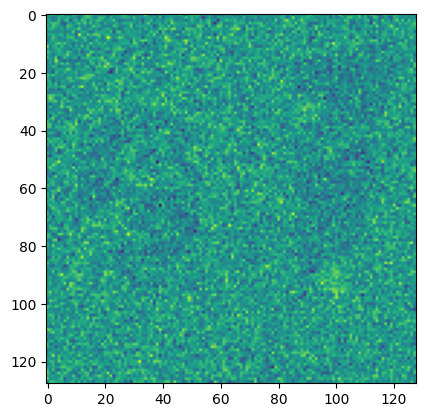

In [62]:
plt.imshow(last_frame[10].detach().cpu())

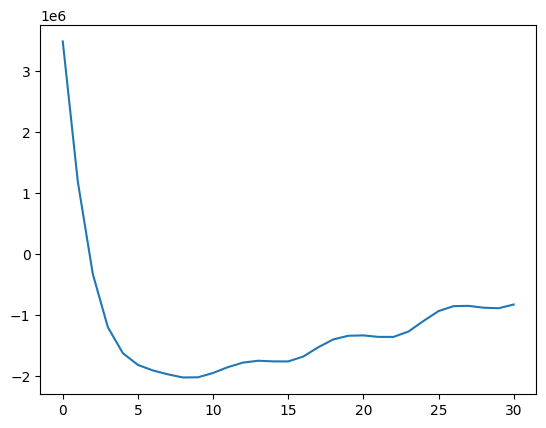

In [48]:
vs = nca_out.reshape(nca_out.shape[0], -1).sum(axis=1).detach().cpu()
plt.plot(vs)

In [49]:
# plt.imshow(last_frame[0].detach().cpu())

In [50]:
# plt.imshow(image[0, 0].detach().cpu())

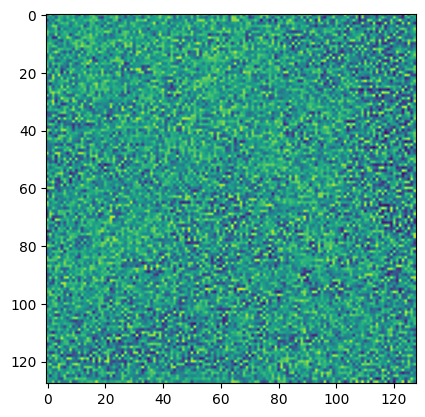

In [52]:
plt.imshow(nca_out[0, 0, 0].detach().cpu().numpy())

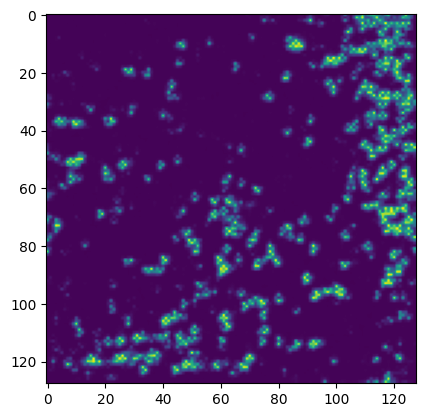

In [53]:
plt.imshow(nca_out[10, 0, 0].detach().cpu().numpy())

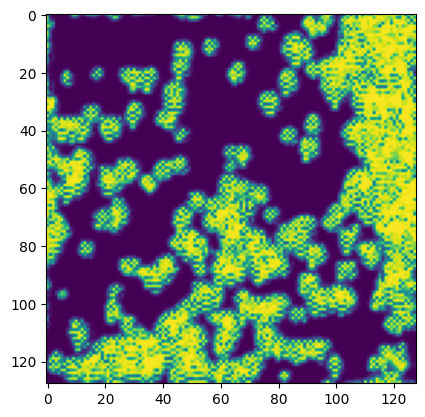

In [51]:
plt.imshow(nca_out[-1, 0, 0].detach().cpu().numpy())

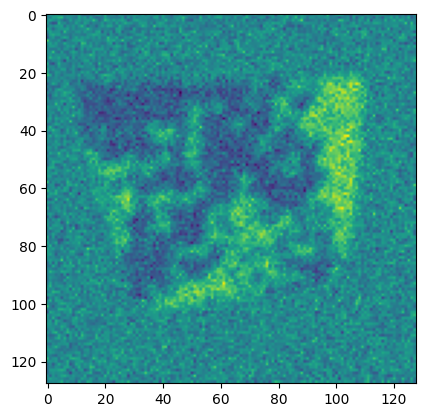

In [77]:
plt.imshow(noiser(nca_out[-1, 0, 0])[0, 0].detach().cpu())

In [41]:
# plt.imshow(nca_out[-1,10,0])

In [42]:
# nca = nca.to("cpu")
# inv_ae = inv_ae.to("cpu")

In [43]:
# msg = inv_ae.sample_msg(bs)
# image = inv_ae.encode(msg)
# image_rep = image.repeat(1, 4, 1, 1)
# nca_out = nca.forward_many(image_rep, steps=steps)
# nca_out = torch.stack(nca_out)

In [44]:
nca_out.shape

torch.Size([31, 100, 4, 128, 128])

In [45]:
nca_out.shape

torch.Size([31, 100, 4, 128, 128])


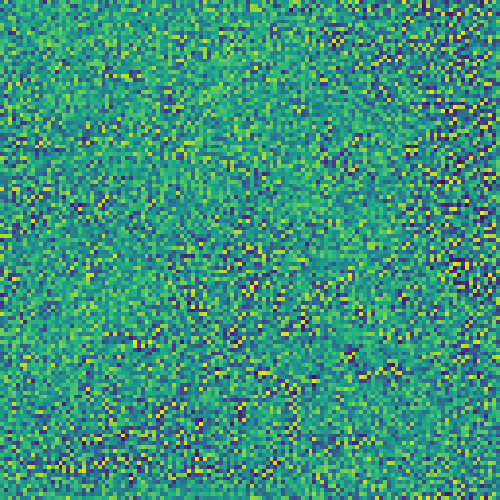

In [46]:
make_gif(nca_out[:,0,0], fps=10)